In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from scipy import stats
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import os

In [16]:
# Set plot style for better visuals
sns.set(style='whitegrid')
data = pd.read_csv('./instagram_data.csv')

# print(data)

# Extract useful features
# data['engagement_rate'] = (data.no_of_comments + data.likes) / data.follower_count_at_t
data['post_time'] = pd.to_datetime(data['t'], unit='s')

# Create cyclical encodings as this time data is cyclical
# data['hour_sin'] = np.sin(2 * np.pi * data['post_time'].dt.hour / 24)  # Extract hour of the day (0-23)
# data['hour_cos'] = np.cos(2 * np.pi * data['post_time'].dt.hour / 24)  # Extract hour of the day (0-23)

# data['day_sin'] = np.sin(2 * np.pi * data['post_time'].dt.dayofweek / 7)  # Extract day of the week (0=Monday, 6=Sunday)
# data['day_cos'] = np.cos(2 * np.pi * data['post_time'].dt.dayofweek / 7)

data['month_sin'] = np.sin(2 * np.pi * data['post_time'].dt.month / 12)  # Extract the month (1-12)
data['month_cos'] = np.cos(2 * np.pi * data['post_time'].dt.month / 12)

# Drop the original timestamp column if no longer needed
data.drop(columns=['t'], inplace=True)
image_paths = data['image_path']
data = data.drop(columns=['image_path'])
data = data.drop(columns = ['post_time'])

# Delete outliers
data = data[data.no_of_comments < 10000]
data = data[data.no_of_comments > 0]

# !Uncomment if including no_of_comments
# data = data.drop(columns= ['no_of_comments']) 

if 'no_of_comments' in data.columns:
    # Apply log transformation to reduce skewness
    data['log_no_of_comments'] = np.log1p(data['no_of_comments'])  # log1p to avoid issues with log(0)
    # data['box_follower_count'], lambda_ = stats.boxcox(data['follower_count_at_t'] + 1)  # Avoid boxcox here as there may be data leakage
    data.drop(columns=['no_of_comments'], inplace=True)
data['log_likes'] = np.log1p(data['likes'])
data.drop(columns=['likes'], inplace=True)

In [17]:
# Split data into training and test sets
train_samples = data.sample(n=len(data) - 318, random_state=42)
test_samples = data.drop(train_samples.index)

# Transform training data
scaler = StandardScaler()
x_train = train_samples.drop(columns=['log_likes'])
if 'follower_count_at_t' in x_train.columns:
    x_train['box_follower_count'], lambda_train = stats.boxcox(x_train['follower_count_at_t'] + 1)
    x_train = x_train.drop(columns='follower_count_at_t')
y_train = train_samples[['log_likes']]
# Scale the data
x_train = scaler.fit_transform(x_train)

# Transform test data
x_test = test_samples.drop(columns=['log_likes'])
if 'follower_count_at_t' in x_test.columns:
    x_test['box_follower_count'] = stats.boxcox(x_test['follower_count_at_t'] + 1, lmbda=lambda_train)
    x_test = x_test.drop(columns='follower_count_at_t')
y_test = np.expm1(test_samples[['log_likes']])
# Scale the data
x_test = scaler.transform(x_test)

# Note: y_train is still in log space; convert when needed
# y_train = np.expm1(y_train)

# Train a linear regression model
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

# Predict on test data
y_pred_lr = np.expm1(lr_model.predict(x_test))

# Evaluate the performance
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train.values.ravel())  # Flatten y_train for RandomForest

# Predict on test data
y_pred_rf = np.expm1(rf_model.predict(x_test))

# Evaluate the performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Train a Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(x_train, y_train.values.ravel())

# Predict on test data
y_pred_gb = np.expm1(gb_model.predict(x_test))

# Evaluate the performance
mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

# XGBoost
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1, max_depth=4, alpha=1, n_estimators=1000) 
xg_reg.fit(x_train, y_train)

# Predict on the test set
y_pred_xgb = np.expm1(xg_reg.predict(x_test))

# Evaluate the performance
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Train a Support Vector Machine (SVR) model
param_grid = {
    'C': [1, 10, 100, 1000],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.5, 0.3],
}

# grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5, scoring='r2', verbose=2)
# grid_search.fit(x_train, y_train.values.ravel())

# # # Best hyperparameters from grid search
# best_params = grid_search.best_params_
# print("Best parameters for SVR:", best_params)
###OUTPUT w comment: 1, .5, auto
###OUTPUT w/o comment: 'C': 1000, 'epsilon': 0.5, 'gamma': 'scale'

svr_model = SVR(kernel='rbf', C=1, gamma='auto', epsilon=0.5)
svr_model.fit(x_train, y_train.values.ravel())

# Predict on test data (scaled)
y_pred_svr = np.expm1(svr_model.predict(x_test))

# Evaluate the performance
mse_svr = mean_squared_error(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

Linear Regression Results:
MSE: 13781749830.713865, MAE: 76173.51588868568, R2: 0.5588912850604297

Random Forest Results:
MSE: 6606338115.636854, MAE: 49395.97145822975, R2: 0.78855273441762

Gradient Boosting Results:
MSE: 8138906076.706842, MAE: 53926.48584334541, R2: 0.7395002489082293

XGBoost Results:
MSE: 5769167267.695542, MAE: 45666.51951282429, R2: 0.8153478503227234

SVM Results:
MSE: 11818047007.124704, MAE: 69334.27886407837, R2: 0.6217429867439273


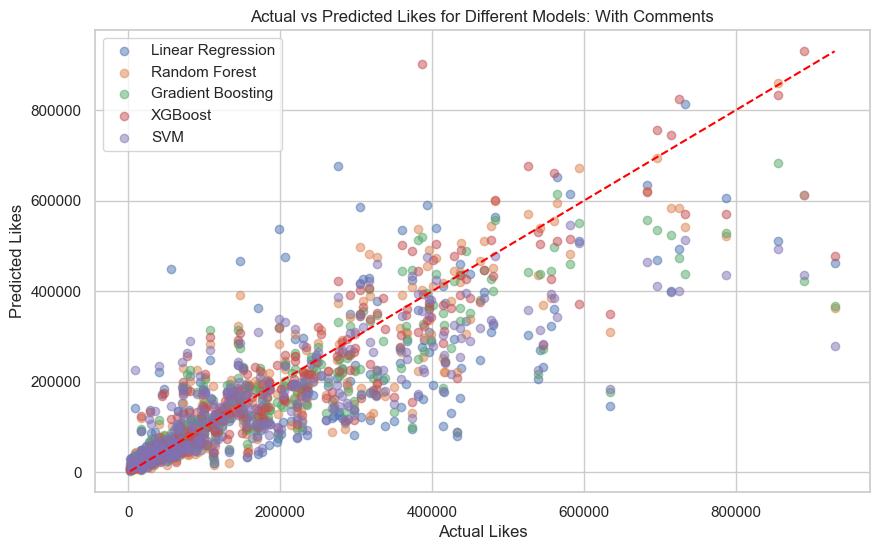

In [18]:
print("Linear Regression Results:")
print(f"MSE: {mse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print("\nRandom Forest Results:")
print(f"MSE: {mse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print("\nGradient Boosting Results:")
print(f"MSE: {mse_gb}, MAE: {mae_gb}, R2: {r2_gb}")
print("\nXGBoost Results:")
print(f"MSE: {mse_xgb}, MAE: {mae_xgb}, R2: {r2_xgb}")
print("\nSVM Results:")
print(f"MSE: {mse_svr}, MAE: {mae_svr}, R2: {r2_svr}")
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_lr, label='Linear Regression', alpha=0.5)
plt.scatter(y_test, y_pred_rf, label='Random Forest', alpha=0.5)
plt.scatter(y_test, y_pred_gb, label='Gradient Boosting', alpha=0.5)
plt.scatter(y_test, y_pred_xgb, label='XGBoost', alpha=0.5)
plt.scatter(y_test, y_pred_svr, label='SVM', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Likes')
plt.ylabel('Predicted Likes')
plt.title('Actual vs Predicted Likes for Different Models: With Comments')
plt.legend()
# plt.xlim(-0.134, -0.132)
# plt.ylim(0,5)
plt.show()

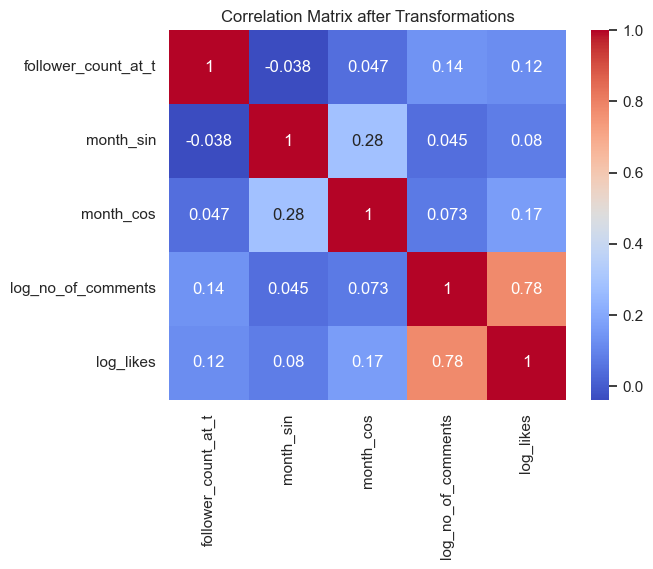

In [19]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix after Transformations')
plt.show()


In [20]:
data['image_path'] = image_paths
data['box_follower_count'] = stats.boxcox(data['follower_count_at_t'] + 1, lmbda=lambda_train)
data = data.drop(columns=['follower_count_at_t'])
print(data.columns)
data.to_csv('./new_instagram_data.csv')

Index(['follower_count_at_t', 'month_sin', 'month_cos', 'log_no_of_comments',
       'log_likes', 'image_path', 'box_follower_count'],
      dtype='object')
